# Results

This notebook is intended as a raw report of the MoveToBeacon challange, where I will discuss all the results (good and bad) that I will get along the way and the ideas obtained from observing them.

In [1]:
import sys
sys.path.insert(0, "../")
from Utils import utils, plot
import numpy as np
import matplotlib.pyplot as plt

# Scripted agent

In [2]:
load_dir = "Results/MoveToBeacon/"
scripted_dict = np.load(load_dir+'scripted_agent_evaluation.npy', allow_pickle=True).item()

In [3]:
mean_score = scripted_dict['mean_score']
std_score = scripted_dict['std_score']
score = scripted_dict['score']

In [4]:
print("Scripted agent score: %.2f +/- %.2f"%(mean_score, std_score))

Scripted agent score: 25.87 +/- 1.91


In [5]:
bins = np.unique(score)-0.5
bins = np.concatenate([bins, np.array([bins[-1]+1])])
bins

array([20.5, 21.5, 22.5, 23.5, 24.5, 25.5, 26.5, 27.5, 28.5, 29.5, 30.5,
       31.5, 32.5])

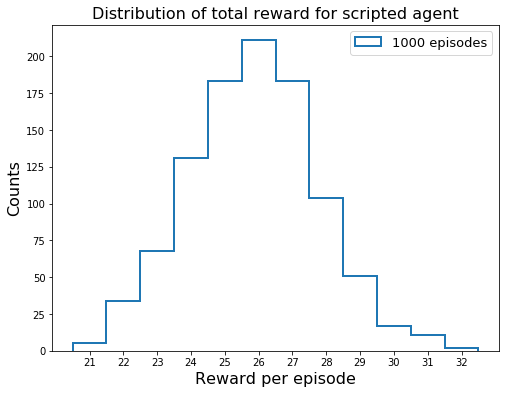

In [6]:
plt.figure(figsize=(8,6))
n, bins, _ = plt.hist(score, bins=bins, histtype='step', lw=2, label='1000 episodes')
plt.xticks(np.arange(21,33))
plt.xlabel("Reward per episode", fontsize=16)
plt.ylabel("Counts", fontsize=16)
plt.title("Distribution of total reward for scripted agent", fontsize=16)
plt.legend(fontsize=13)
plt.show()

Being random the locations where the beacons are spawned, even the results of a deterministic policy are stochastic because of the game, so we can expect the same for our trained agent.

# Agent 1

In [2]:
load_dir = "Results/MoveToBeacon/"
queries = ['agent1','3000-episodes']
train_dict = utils.load_session(load_dir, queries)

Number of matching filenames: 1
 ['S_agent1_3000-episodes_240-steps_XMLT.npy']


In [3]:
game_params = train_dict['game_params']
HPs = train_dict['HPs']
score = train_dict['score']
losses = train_dict['losses']
keywords = train_dict['keywords']
ID = keywords[-1]

In [30]:
L = int(len(score)/6)
asymptotic_score = score[-L:].mean()
asymptotic_err = score[-L:].std()
print("Asymptotic performance: %.2f +/- %.2f"%(asymptotic_score, asymptotic_err))
print("Scripted agent score:   %.2f +/- %.2f"%(mean_score, std_score))

Asymptotic performance: 25.66 +/- 1.88
Scripted agent score:   25.87 +/- 1.91


As we can see, the asymptotic performance is almost equal to that of the scripted agent.

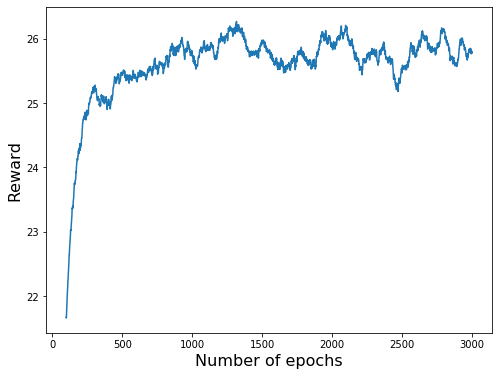

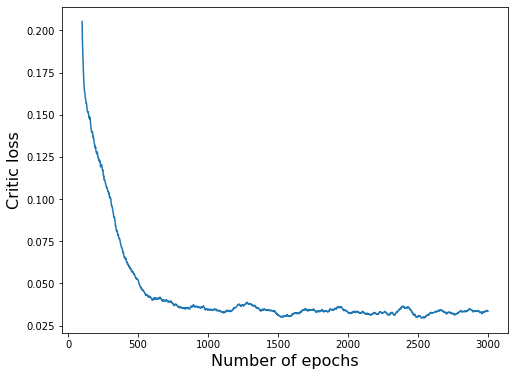

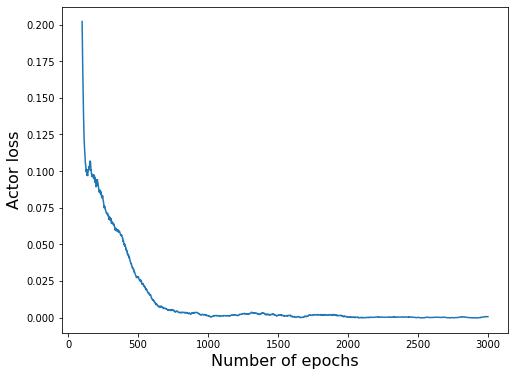

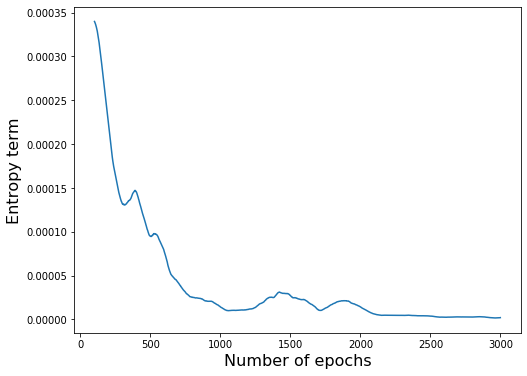

In [5]:
plot.plot_session(score, losses, moving_average=True)

**Results:**
- Convergence: 1000 epochs
- Asymptotic performance: 25.83 +/- 1.85

**Hyper-parameters:**
- Architecture: MLP with hidden dimension [64,32,16] 
- Learning rate: 5e-4 
- Discount factor: 0.9 
- Tau: 0.1 
- n-steps: 40 
- H: 1e-3 
- solver: Adam

# Agent 2

In [10]:
load_dir = "Results/MoveToBeacon/"
queries = ['agent2']
train_dict = utils.load_session(load_dir, queries)

Number of matching filenames: 1
 ['S_agent2_1000-episodes_240-steps_WYWL.npy']


In [11]:
game_params = train_dict['game_params']
HPs = train_dict['HPs']
score = train_dict['score']
losses = train_dict['losses']
keywords = train_dict['keywords']
ID = keywords[-1]

In [12]:
L = int(len(score)/6)
asymptotic_score = score[-L:].mean()
asymptotic_err = score[-L:].std()
print("Asymptotic performance: %.2f +/- %.2f"%(asymptotic_score, asymptotic_err))
print("Scripted agent score:   %.2f +/- %.2f"%(mean_score, std_score))

Asymptotic performance: 26.01 +/- 1.89
Scripted agent score:   25.87 +/- 1.91


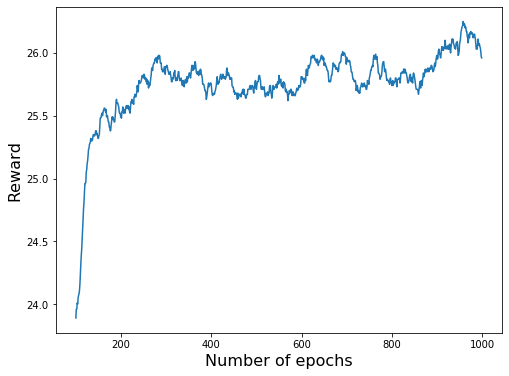

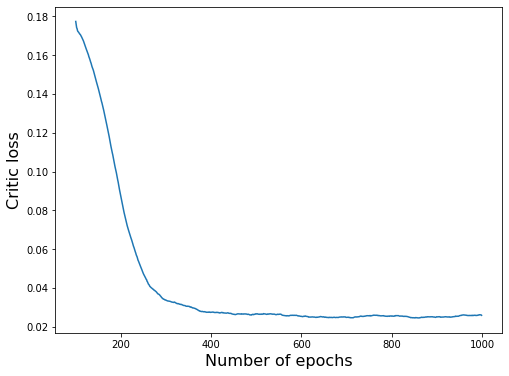

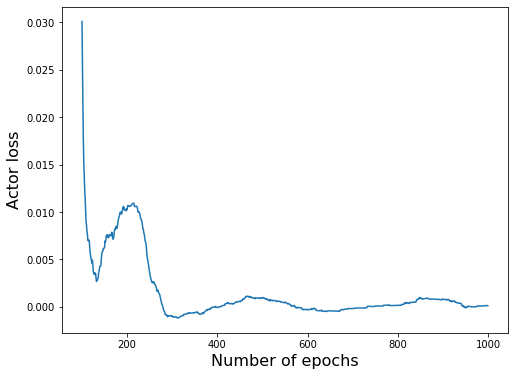

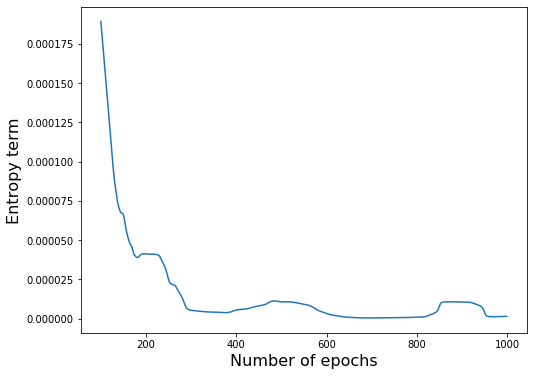

In [13]:
plot.plot_session(score, losses, moving_average=True)

**Results:**
- Convergence: less than 1000 epochs
- Asymptotic performance: 26.01 +/- 1.89

**Hyper-parameters:**
- Learning rate: 5e-4 
- Discount factor: 0.9 
- Tau: 0.3
- n-steps: 5
- H: 1e-3 
- solver: Adam

**Architecture:**
```python
class OheNet(nn.Module):
    """Learns a vectorial state representation starting from a multi-channel image-like state."""
    
    def __init__(self, map_size, k_in=3, k_out=24, n_features=32, pixel_hidden_dim=128, 
                 pixel_n_residuals=4, feature_hidden_dim=64, feature_n_residuals=4):
        """
        map_size: int
            If input is (batch_dim, n_channels, linear_size, linear_size), then map_size = linear_size - 2
        k_in: int (default 3)
            Number of channels of the input "image"
        k_out: int (default 24)
            Number of channels at the end of the two convolutional layers
        n_features: int (default 32)
            Number of features extracted from each pixel - obtained through a linear projection of the channel axis 
            pixel-wise
        pixel_hidden_dim: int (default 128)
            Number of neurons in the hidden layers of the pixel residual layers
        pixel_n_residuals: int (default 4)
            Number of pixel residual layers
        feature_hidden_dim: int (default 64)
            Number of neurons in the hidden layers of the feature residual layers
        feature_n_residuals: int (default 4)
            Number of feature residual layers
        """
        
        super(OheNet, self).__init__()
        
        self.n_features = n_features
        
        self.OHE_conv = Convolution(k_in=k_in, k_out=k_out)
        self.pos_enc = PositionalEncoding(n_kernels=k_out, n_features=n_features)

        pixel_res_layers = nn.ModuleList([ResidualLayer(map_size**2, pixel_hidden_dim) 
                                          for _ in range(pixel_n_residuals)])
        self.pixel_res_block = nn.Sequential(*pixel_res_layers)

        self.maxpool = FeaturewiseMaxPool(pixel_axis=2)

        feature_res_layers = nn.ModuleList([ResidualLayer(n_features, feature_hidden_dim) 
                                            for _ in range(feature_n_residuals)])
        self.feature_res_block = nn.Sequential(*feature_res_layers)
        
    def forward(self, x):
        """ Input shape (batch_dim, k_in, map_size+2, map_size+2) """      
        x = self.OHE_conv(x)      
        x = self.pos_enc(x)          
        x = x.permute(1,2,0)          
        x = self.pixel_res_block(x) # Interaction between pixels feature-wise            
        x = self.maxpool(x) # Feature-wise maxpooling            
        x = self.feature_res_block(x) # Interaction between features -> final representation
        return x 
```

# Agent 3

In [4]:
load_dir = "Results/MoveToBeacon/"
queries = ['agent3', '3000-episodes']
train_dict = utils.load_session(load_dir, queries)

Number of matching filenames: 1
 ['S_agent3_TD(40)_3000-episodes_240-steps_APPD.npy']


In [10]:
game_params = train_dict['game_params']
HPs = train_dict['HPs']
score = train_dict['score']
losses = train_dict['losses']
keywords = train_dict['keywords']
ID = keywords[-1]
print("HPs: ", HPs)

HPs:  {'action_space': 3, 'map_size': 14, 'lr': 1e-05, 'gamma': 0.9, 'TD': True, 'twin': True, 'tau': 0.3, 'n_steps': 40, 'H': 0.001}


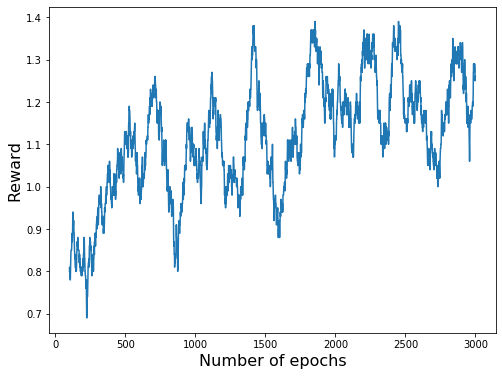

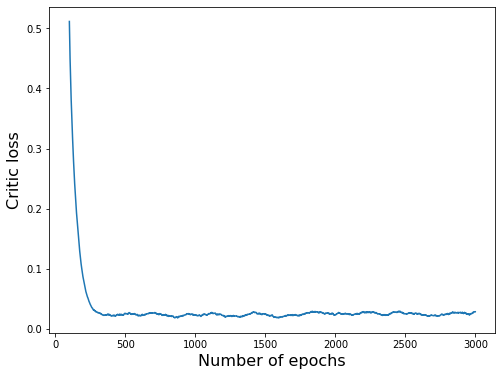

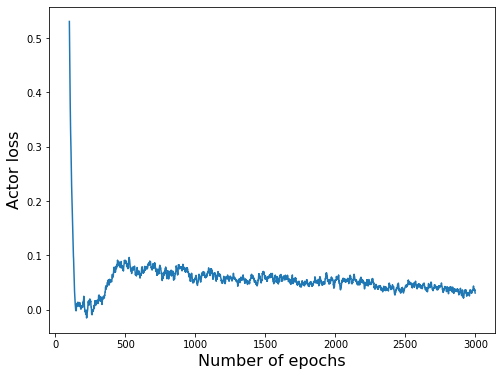

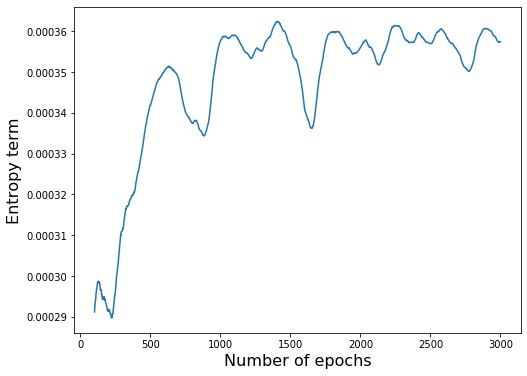

In [8]:
plot.plot_session(score, losses, moving_average=True)

In [11]:
load_dir = "Results/MoveToBeacon/"
queries = ['agent3', '5000-episodes']
train_dict = utils.load_session(load_dir, queries)

Number of matching filenames: 1
 ['S_agent3_TD(20)_lr-1e-5_critic-lr-1e-4_5000-episodes_240-steps_IUKU.npy']


In [12]:
game_params = train_dict['game_params']
HPs = train_dict['HPs']
score = train_dict['score']
losses = train_dict['losses']
keywords = train_dict['keywords']
ID = keywords[-1]
print("HPs: ", HPs)

HPs:  {'action_space': 3, 'map_size': 14, 'lr': 1e-05, 'critic_lr': 0.0001, 'gamma': 0.99, 'TD': True, 'twin': True, 'tau': 0.3, 'n_steps': 20, 'H': 0.001, 'device': 'cuda'}


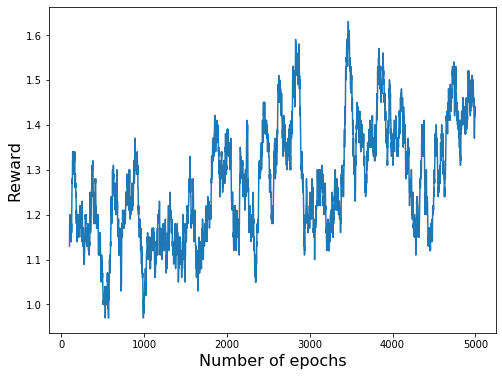

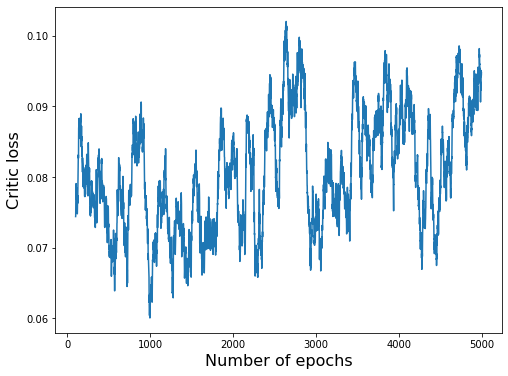

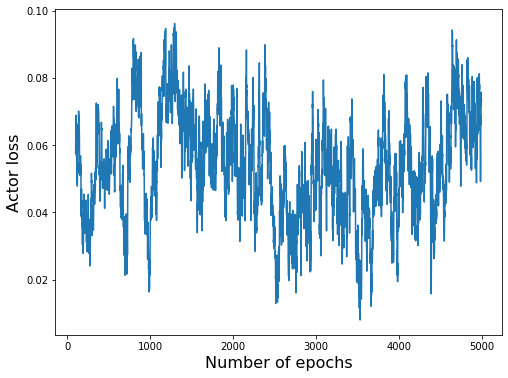

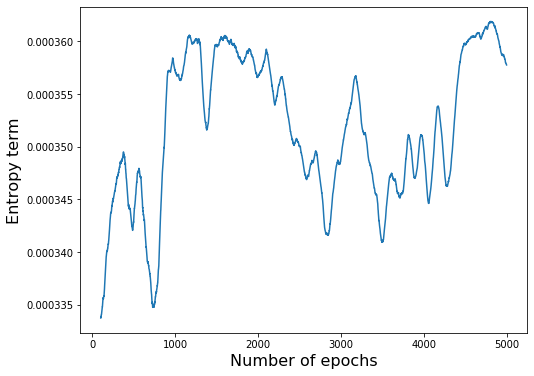

In [13]:
plot.plot_session(score, losses, moving_average=True)

# Agent 4

In [2]:
load_dir = "Results/MoveToBeacon/"
queries = ['agent4', '5000-episodes']
train_dict = utils.load_session(load_dir, queries)

Number of matching filenames: 1
 ['S_agent4_TD(20)_lr-1e-5_critic-lr-1e-4_5000-episodes_240-steps_LMBD.npy']


In [3]:
game_params = train_dict['game_params']
HPs = train_dict['HPs']
score = train_dict['score']
losses = train_dict['losses']
keywords = train_dict['keywords']
ID = keywords[-1]
print("HPs: ", HPs)

HPs:  {'action_space': 3, 'n_layers': 2, 'in_channels': 3, 'n_channels': 12, 'linear_size': 16, 'lr': 1e-05, 'critic_lr': 0.0001, 'gamma': 0.99, 'TD': True, 'twin': True, 'tau': 0.3, 'n_steps': 20, 'H': 0.001, 'pixel_n_residuals': 2, 'feature_n_residuals': 2, 'device': 'cuda'}


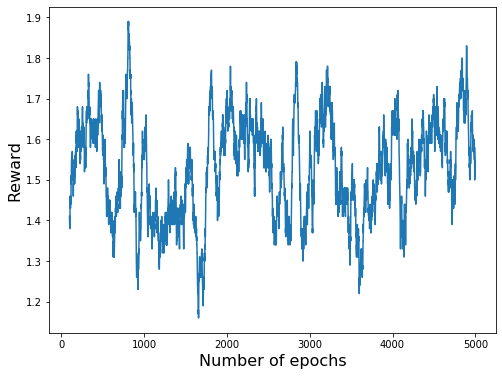

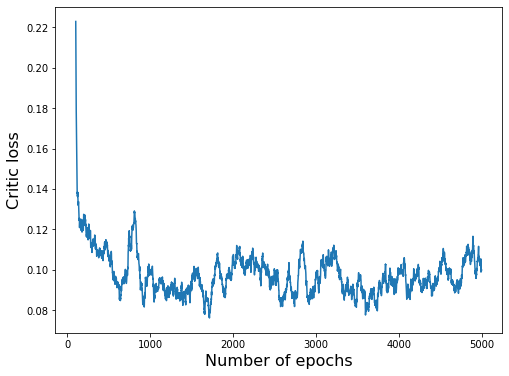

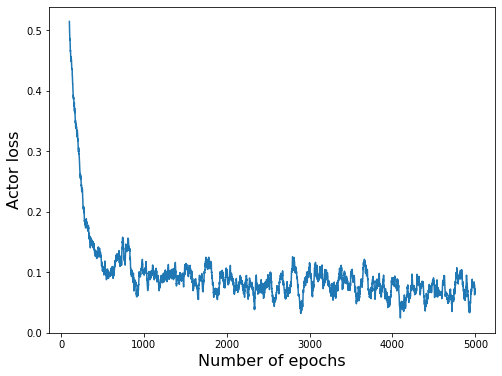

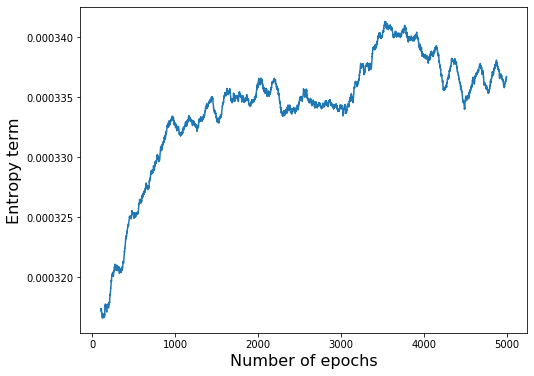

In [4]:
plot.plot_session(score, losses, moving_average=True)

# Agent 4 - batched A2C version

In [5]:
load_dir = "Results/MoveToBeacon/"
queries = ['A2C', '120k-env-steps','JCMN.npy']
train_dict = utils.load_session(load_dir, queries)

Number of matching filenames: 1
 ['S_A2C_conv-net_lr-7e-4_20-steps_120k-env-steps_240-unroll-len_JCMN.npy']


In [6]:
game_params = train_dict['game_params']
HPs = train_dict['HPs']
score = train_dict['score']
losses = train_dict['losses']
keywords = train_dict['keywords']
ID = keywords[-1]
print("HPs: ", HPs)

HPs:  {'action_space': 3, 'gamma': 0.99, 'n_steps': 20, 'H': 0.001, 'spatial_model': <class 'AC_modules.Networks.FullyConvSpatial'>, 'nonspatial_model': <class 'AC_modules.Networks.FullyConvNonSpatial'>, 'n_features': 256, 'n_channels': 32, 'spatial_dict': {'in_channels': 2}, 'nonspatial_dict': {'resolution': 16}, 'device': 'cuda'}


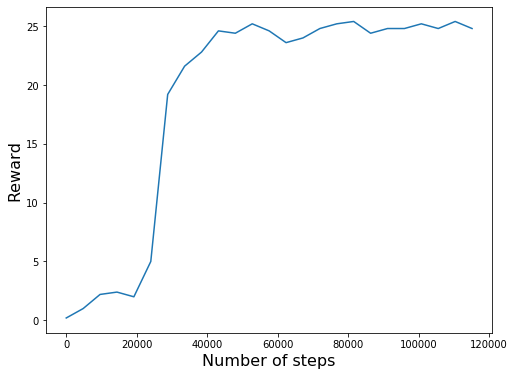

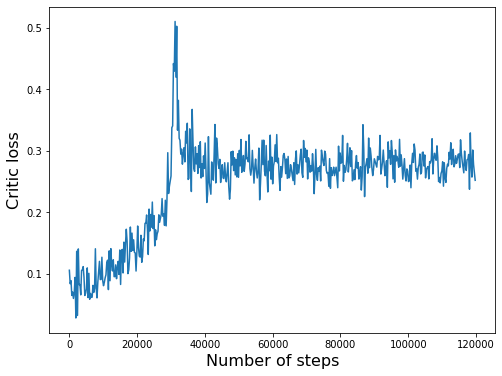

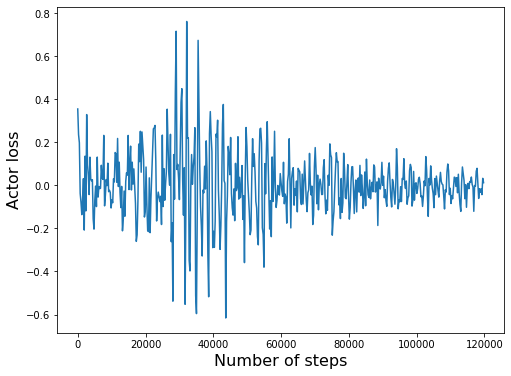

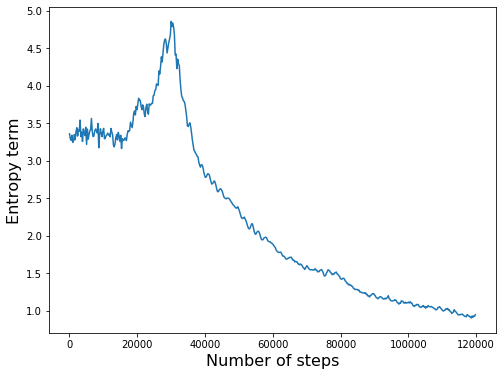

In [9]:
plot.plot_bA2C_session(score, losses, unroll_length=240, test_interval=20, moving_average=False)

# Collect Mineral Shards

Same architecture of MoveToBeacon except for the fact that accepts a custom number of layers and of actions.
FIrst samples actions, then embed them and concatenates them to both spatial and non-spatial features to sample the parameters in a way that is conditioned by the action.

In [29]:
load_dir = "../Results/CollectMineralShards/"
queries = ["YOEI-full.npy"]
train_dict = utils.load_session(load_dir, queries)

Number of matching filenames: 1
 ['S_A2C_CMS_conv-net_lr-7e-4_20-steps_32x32_120k-env-steps_120-unroll-len_32-channels_YOEI-full.npy']


In [30]:
game_params = train_dict['game_params']
HPs = train_dict['HPs']
score = train_dict['score']
losses = train_dict['losses']
keywords = train_dict['keywords']
ID = keywords[-1]
print("HPs: ", HPs)

HPs:  {'action_space': 6, 'gamma': 0.99, 'n_steps': 20, 'H': 0.001, 'spatial_model': <class 'AC_modules.Networks.FullyConvSpatial'>, 'nonspatial_model': <class 'AC_modules.Networks.FullyConvNonSpatial'>, 'n_features': 256, 'n_channels': 32, 'spatial_dict': {'in_channels': 7}, 'nonspatial_dict': {'resolution': 32, 'kernel_size': 3, 'stride': 2}, 'action_dict': {0: <_Functions.no_op: 0>, 1: <_Functions.select_army: 7>, 2: <_Functions.Attack_screen: 12>, 3: <_Functions.Move_screen: 331>, 4: <_Functions.select_point: 2>, 5: <_Functions.select_rect: 3>}, 'embed_dim': 8, 'device': 'cuda'}


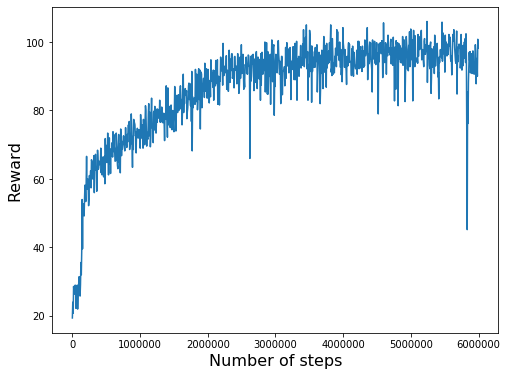

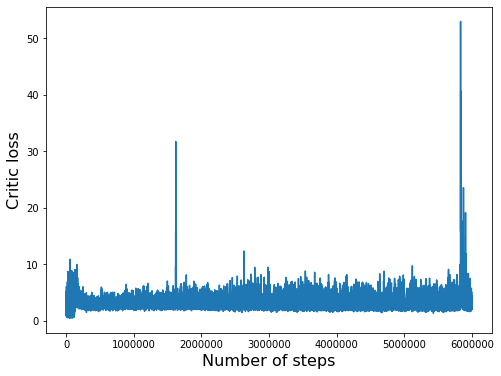

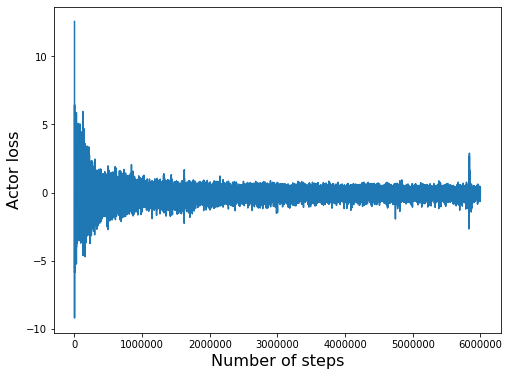

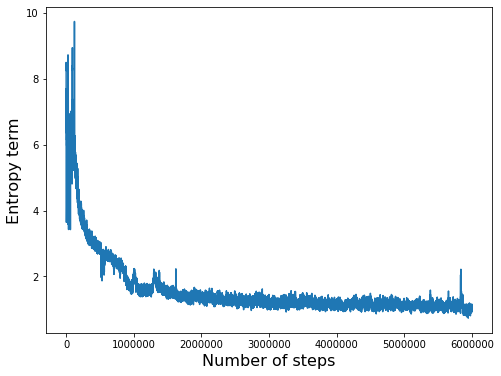

In [35]:
plot.plot_bA2C_session(score, losses, unroll_length=120, test_interval=50, moving_average=False)

# FindAndDefeatZerglings

In [2]:
load_dir = "../Results/FindAndDefeatZerglings/"
queries = ["PRGY.npy"]
train_dict = utils.load_session(load_dir, queries)

Number of matching filenames: 2
 ['S_FindAndDefeatZerglings_lr-0.0007_20-steps_32-res_3600000-env-steps_60-unroll-len_36-in-channels_PRGY.npy', 'S_FindAndDefeatZerglings_lr-0.0007_20-steps_32-res_1200000-env-steps_60-unroll-len_36-in-channels_PRGY.npy']


In [3]:
game_params = train_dict['game_params']
HPs = train_dict['HPs']
score = train_dict['score']
losses = train_dict['losses']
keywords = train_dict['keywords']
ID = keywords[-1]
print("HPs: ", HPs)

TypeError: list indices must be integers or slices, not str

In [ ]:
step_idx//6000

In [13]:
len(score)*6000

3600000

In [16]:
len(losses['critic_losses'])*60

3600000

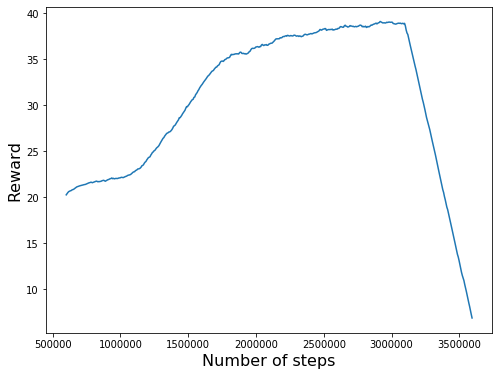

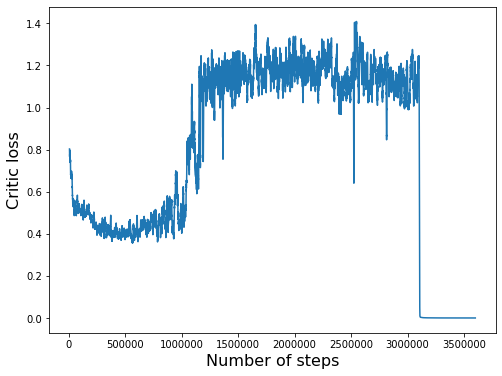

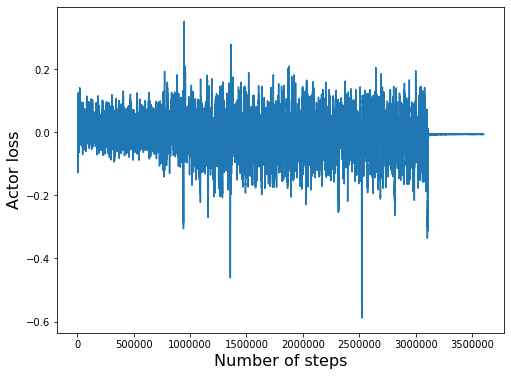

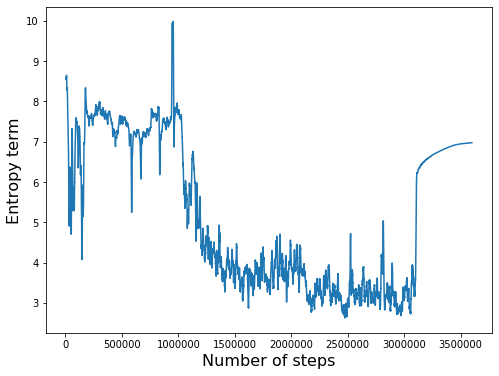

In [7]:
plot.plot_bA2C_session(score, losses, unroll_length=60, test_interval=100, moving_average=True)

# Old stuff

In [8]:
load_dir = "Results/MoveToBeacon/"
queries = ['batched-A2C',"fully-conv", "lr-1e-3",'1.2M-env-steps',"COYJ.npy"]
train_dict = utils.load_session(load_dir, queries)

Number of matching filenames: 1
 ['S_batched-A2C_fully-conv_lr-1e-3_5-steps_1.2M-env-steps_240-steps_COYJ.npy']


In [9]:
game_params = train_dict['game_params']
HPs = train_dict['HPs']
score = train_dict['score']
losses = train_dict['losses']
keywords = train_dict['keywords']
ID = keywords[-1]
print("HPs: ", HPs)

HPs:  {'action_space': 3, 'gamma': 0.99, 'n_steps': 5, 'spatial_model': <class 'AC_modules.Networks.FullyConvSpatial'>, 'nonspatial_model': <class 'AC_modules.Networks.FullyConvNonSpatial'>, 'n_features': 256, 'n_channels': 32, 'spatial_dict': {'in_channels': 3}, 'nonspatial_dict': {}, 'device': 'cuda'}


In [10]:
load_dir = "Results/MoveToBeacon/"
queries = ['batched-A2C',"fully-conv", "lr-1e-3",'1.2M-env-steps',"COYJ-pt2"]
train_dict = utils.load_session(load_dir, queries)

Number of matching filenames: 1
 ['S_batched-A2C_fully-conv_lr-1e-3_5-steps_1.2M-env-steps_240-steps_COYJ-pt2_WUCM.npy']


In [11]:
game_params = train_dict['game_params']
HPs = train_dict['HPs']
score1 = train_dict['score']
losses1 = train_dict['losses']
keywords = train_dict['keywords']
ID = keywords[-1]
print("HPs: ", HPs)

HPs:  {'action_space': 3, 'gamma': 0.99, 'n_steps': 5, 'spatial_model': <class 'AC_modules.Networks.FullyConvSpatial'>, 'nonspatial_model': <class 'AC_modules.Networks.FullyConvNonSpatial'>, 'n_features': 256, 'n_channels': 32, 'spatial_dict': {'in_channels': 3}, 'nonspatial_dict': {}, 'device': 'cuda'}


In [17]:
score_tot = np.concatenate([score,score1])
loss = {}
for k in losses:
    loss[k] = np.concatenate([losses[k],losses1[k]])

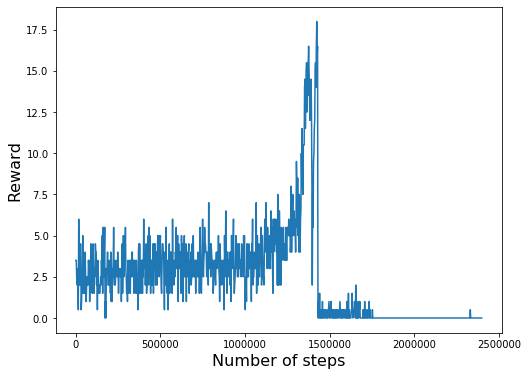

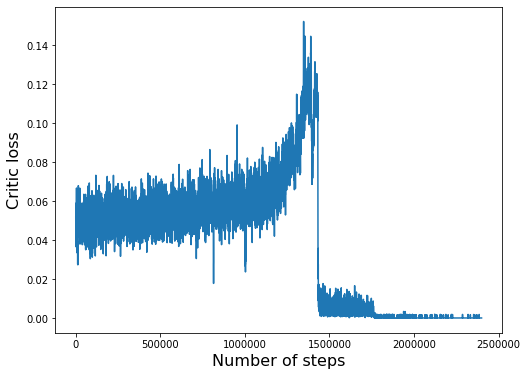

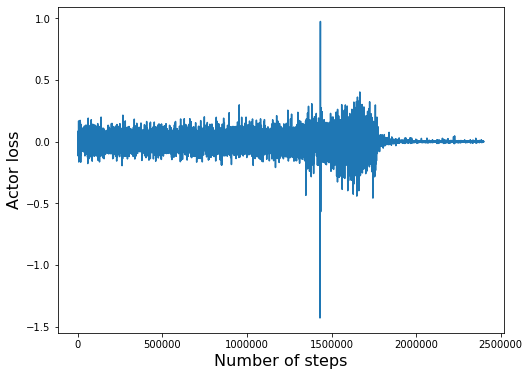

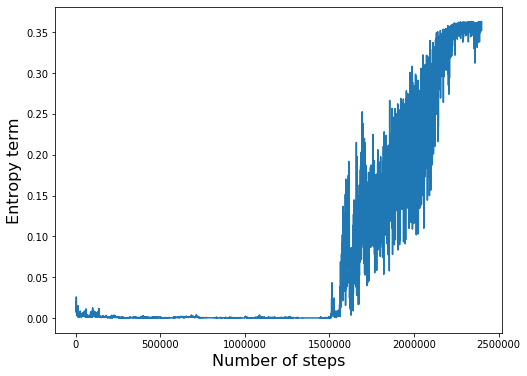

In [100]:
plot.plot_bA2C_session(score_tot, loss, unroll_length=240, test_interval=10, moving_average=False, average_window=10)

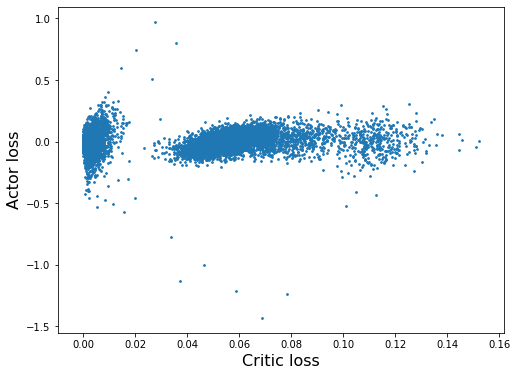

In [25]:
plt.figure(figsize=(8,6))
plt.scatter(loss['critic_losses'], loss["actor_losses"], s=3)
plt.xlabel("Critic loss", fontsize=16)
plt.ylabel("Actor loss", fontsize=16)
plt.show()

In [30]:
def decimate_results(losses, n=10):
    def dec_array(x, n):
        return np.array([x[i] for i in range(len(x)) if i%n==0 ])
    
    dec_losses = {}
    for k in losses.keys():
        dec_losses[k] = dec_array(losses[k], n)
        
    return dec_losses

In [31]:
dec_losses = decimate_results(loss)

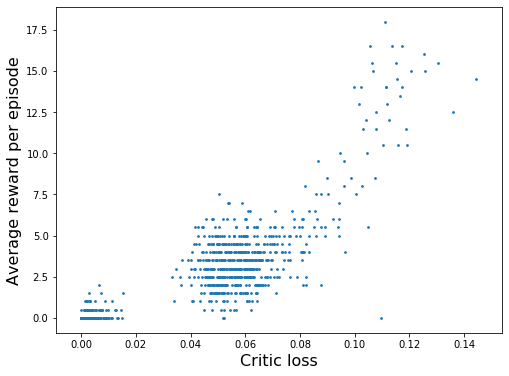

In [34]:
plt.figure(figsize=(8,6))
plt.scatter(dec_losses['critic_losses'], score_tot, s=3)
plt.xlabel("Critic loss", fontsize=16)
plt.ylabel("Average reward per episode", fontsize=16)
plt.show()

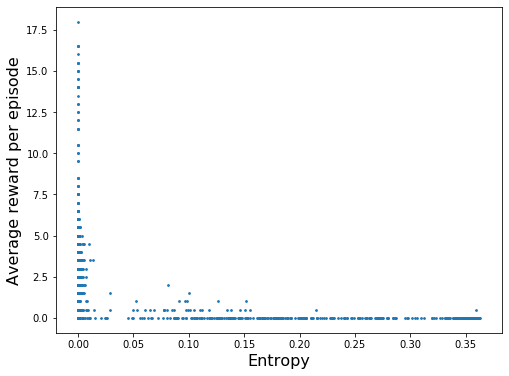

In [76]:
plt.figure(figsize=(8,6))
plt.scatter(-dec_losses['entropies'], score_tot, s=3)
plt.xlabel("Entropy", fontsize=16)
plt.ylabel("Average reward per episode", fontsize=16)
plt.show()

In [46]:
X = dec_losses['critic_losses']
Y = score_tot
Z = dec_losses['actor_losses']
W = dec_losses['entropies']

In [67]:
def cross_corr(X,Y):
    cc = np.array([np.mean(X[:-tau]*Y[tau:]) for tau in range(1,int(len(X)/2))])
    return cc

def plot_CC(X,Y, title):
    cc = cross_corr(X,Y)
    plt.figure(figsize=(8,6))
    plt.plot(np.arange(len(cc)), cc)
    plt.title(title, fontsize=16)
    plt.xlabel("Time lag", fontsize=16)
    plt.ylabel("Cross-Correlation", fontsize=16)
    plt.show()

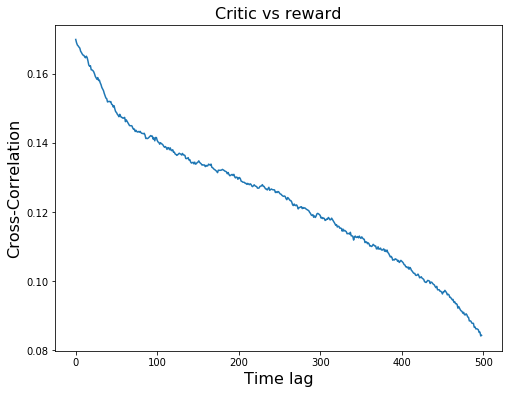

In [68]:
plot_CC(X,Y, "Critic vs reward")

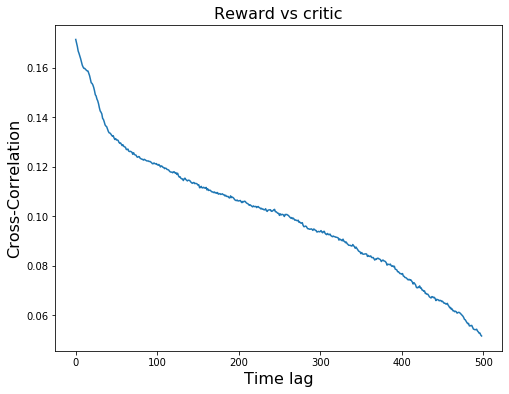

In [69]:
plot_CC(Y, X, "Reward vs critic")

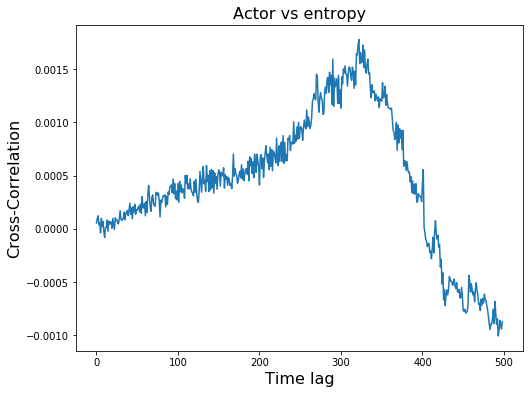

In [70]:
plot_CC(Z,W, "Actor vs entropy")

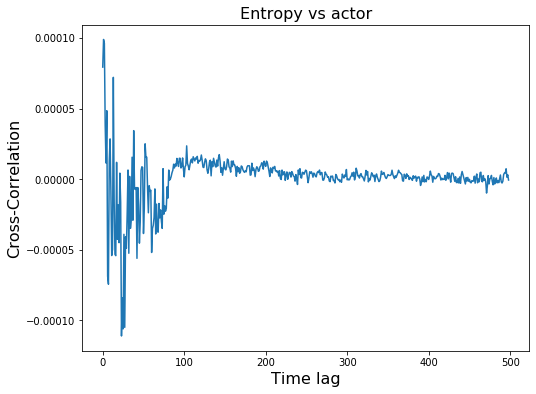

In [71]:
plot_CC(W,Z, "Entropy vs actor")

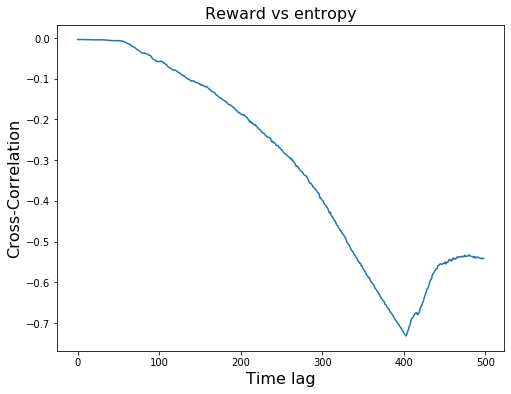

In [72]:
plot_CC(Y,W, "Reward vs entropy") 

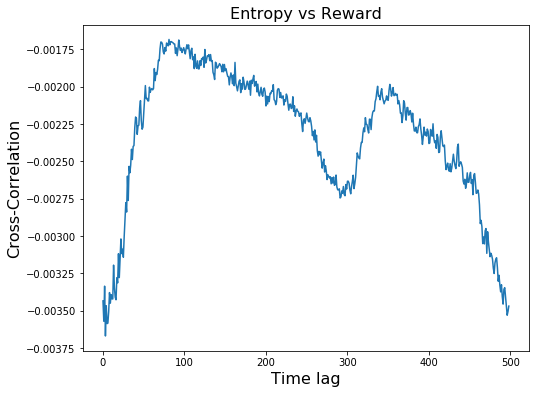

In [73]:
plot_CC(W,Y, "Entropy vs Reward")

# Time of biggest fluctuation

In [96]:
def plot_derivative(x):
    dx = x[1:] - x[:-1]
    plt.plot(np.arange(len(dx)), dx)

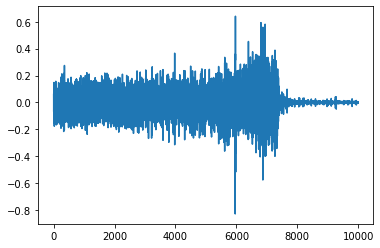

In [97]:
a = loss['actor_losses']
plot_derivative(a)

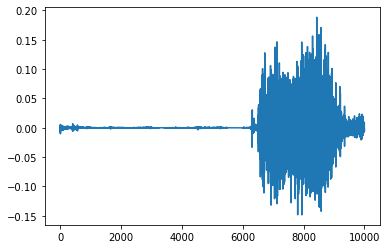

In [98]:
e = loss["entropies"]
plot_derivative(e)

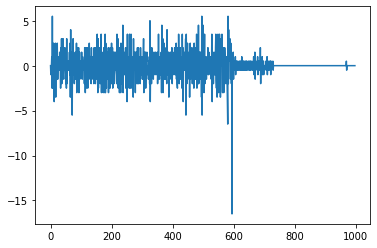

In [99]:
r = score_tot
plot_derivative(r)